## Version, imports and hepler functions

In [1]:
import sys
print(sys.version)

3.10.6 (main, Aug  2 2022, 15:11:03) [GCC 7.5.0]


In [2]:
from skimage import io, img_as_ubyte
from skimage.color import rgb2gray, rgba2rgb
from skimage.feature import match_template, peak_local_max, canny, corner_peaks, corner_harris, corner_subpix
from skimage.filters import threshold_otsu, try_all_threshold, threshold_minimum, threshold_triangle
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np

In [3]:
def plot_img(img:np.ndarray) -> None:
    plt.imshow(img)
    

## Load Image
In this version we will work on the assumption that the image we recieve will always be a PNG. The only thing we have to make sure is we are working with a RGB type of image instead of a RGBa type.
Checking the number of values the matrix retains for each pixel should do the trick, as for RGB you anly hold 3 but for RGBa you hold 4.

In [4]:
def load_img(image_path:str) -> np.ndarray:
    # Load data from file
    img:np.ndarray = io.imread(image_path)
    
    if img.shape[2] == 4:
        # RGBA => RGB
        img = rgba2rgb(img)
    return img

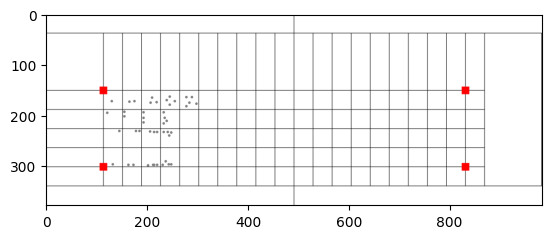

In [5]:
img = load_img('bitmap1.png')
plot_img(img)

## Find the area between the red points
I will also refer to this area as the data area as the information the player enters will be in this area.

### Determinie which red point it is
To find the center of each marker given n coordinates relatives to each marker

In [6]:
def center_of_clusters(cluster_coors:np.ndarray, height:int, width:int) -> np.array:
    mid_h = height / 2
    mid_w = width / 2
    
    # We know there are 4 clusters but not how many dots in each cluster
    # Knowing the distribution we can separate them by position given where
    # they are in the image, topRight, topLeft, bottomRight and bottomLeft
    clusters = [[0,0,0],[0,0,0],[0,0,0],[0,0,0]]
    
    # Classify coords
    for y,x in cluster_coors:
        if y < mid_h:
            if x < mid_w:
                i = 0
            else:
                i = 1
        else:
            if x < mid_w:
                i = 2
            else:
                i = 3
        clusters[i][0] += 1  # Number of points in this cluster
        clusters[i][1] += y  # Sum of all y coords of the cluster
        clusters[i][2] += x  # Sum of all x coords of the cluster
        
        #print('========')
        #print(i)
        #print('y:{} mid_h:{} x:{}, mid_w:{}'.format(y, mid_h, x, mid_w))


    # Find the centers for each clusters
    return np.array([[sum_y//total, sum_x//total] for total, sum_y, sum_x in clusters])
    
    
    

### Search for the area in the image
First look for the red in the image and try to find points relative to them. I used corner detection algorithms to ensure the result is the closests to the center of the red marks (when the mean between the points found is computed for each cluster)

In [7]:
def search_data_area(img:np.ndarray) -> np.ndarray:
    
    img2 = img.copy()
    
    # Red markers enclouse the area
    red = np.logical_and(img[:,:, 0] > 0.8, img[:,:,1] < 0.8)
    not_red = np.logical_or(img[:, :, 0] < 0.8, img[:, :, 1] > 0.8)
    
    # Make the red markers white and everything else black
    img[not_red] = [0., 0., 0.]
    img[red] = [1., 1., 1.]
    
    img = rgb2gray(img)
    coords = corner_peaks(corner_harris(img), min_distance=5, threshold_rel=0.4)
    #coords_subpix = corner_subpix(img, coords, window_size=13)
    coords = center_of_clusters(coords, img.shape[0], img.shape[1])
    
    #fig, ax = plt.subplots()
    #ax.imshow(img, cmap=plt.cm.gray)
    #ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
    #ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
    #ax.plot(coords_mine[:, 1], coords_mine[:, 0], '+g', markersize=15)
    #plt.show()
    
    # Delete the red markers
    img2[red] = [1., 1., 1.]
    
    # Cut the image to the area we care
    img2 = img2[ coords[0][0] : coords[3][0], coords[0][1] : coords[3][1] ]
    
    return img2
    

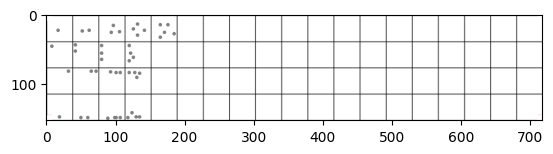

In [8]:
area_img = search_data_area(img)
plot_img(area_img)

## Search for the cells

Get it in high contrast to make it easier to find the lines between the cells

In [9]:
gray_area = rgb2gray(area_img)
t = threshold_otsu(gray_area)
# t = threshold_triangle(area)
# t = threshold_minimum(area)

area_bw = gray_area < t
area_wb = gray_area > t

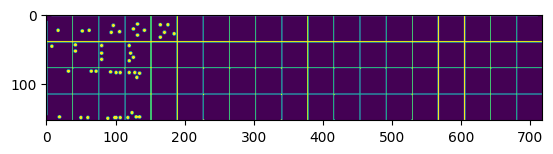

In [10]:
plot_img(area_bw)

In [11]:
def merge_lines(lines:list, threshold:int=5, vertical:bool=True) -> list:
    new_list:list = []
    
    for i, line in enumerate(lines):
        append = True
        for other in lines[i+1:]:
            if not append:
                break

            if vertical:
                append = not (abs(line[0][0] - other[0][0]) < threshold)
            else:
                append = not (abs(line[0][1] - other[0][1]) < threshold)
        if append:
            new_list.append(line)
    return new_list
                

In [12]:
def grid_margins(info_area:np.ndarray):
    lines = probabilistic_hough_line(info_area, threshold=10, line_length=150,line_gap=15)
    
    # Split by orientation (vertial | horizontal)
    
    vertical = []
    horizontal = []
    
    # P starting point of the line, Q ending point of the line
    for p, q in lines:
        m = None # y = mx+b
        
        if p[0] == q[0]:
            # Completly vertical, special case because the slope here is infinite
            # as it results from a division by 0 if we follow the usual forumula for the slope
            m = 900
        elif p[1] == q[1]:
            m = 0.0
        else:
            # Slope formula: m = q.y - p.y / q.x - p.x
            #m = (q[1] - p[1]) / (q[0]-p[0])
            pass
            
        # print(m)
        if m == None:
            continue
        if abs(0 - m) < abs(900 - m):
            horizontal.append((p, q))
        else:
            vertical.append((p, q))
    
    # Add limits
    x_end = info_area.shape[1] - 1
    y_end = info_area.shape[0] - 1
    vertical.append( ( (0, 0), (0, y_end) ) )
    vertical.append( ( (x_end, 0), (x_end, y_end) ) )
    horizontal.append( ( (0, 0), (x_end, 0) ) )
    horizontal.append( ( (0, y_end), (x_end, y_end) ) )
    
    # Merge lines that are too close
    vertical = merge_lines(vertical, threshold=5, vertical=True)
    horizontal = merge_lines(horizontal, threshold=5, vertical=False)
    
    # Sort them
    vertical.sort(key=lambda tup: tup[0][0])
    horizontal.sort(key=lambda tup: tup[0][1])
    
    # Make them start at the start and end at the end
    vertical = [((p[0], info_area.shape[0]-1), (q[0], 0)) for p,q in vertical]
    horizontal = [((info_area.shape[1]-1, p[1]), (0, q[1])) for p,q in horizontal]
    
    return vertical, horizontal
        
    

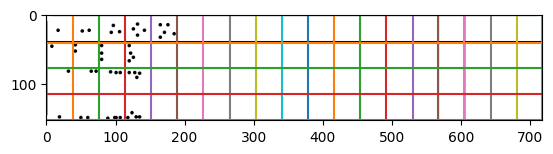

In [13]:
vertical, horizontal = grid_margins(area_bw)
grid = vertical + horizontal

fig, axes = plt.subplots()
axes.imshow(area_wb, cmap='gray')
for line in grid:
    p, q = line
    axes.plot((p[0],q[0]),(p[1], q[1]))
plt.show()

In [14]:
#horizontal.sort(key=lambda tup: tup[0][1])
print(horizontal)
print(len(horizontal))


[((717, 0), (0, 0)), ((717, 40), (0, 40)), ((717, 77), (0, 77)), ((717, 115), (0, 115)), ((717, 152), (0, 152))]
5


In [15]:
def cell_coords(vertical:list, horizontal:list, shape:tuple) -> np.ndarray:
    top = shape[0]
    end = shape[1]
    
    # Get vertical cutting points on horizontal aixis
    where2cutV = [p[0] for p,_ in vertical]
    
    # Assure start and end are included
    if not 0 in where2cutV:
        where2cutV = [0] + where2cutV
    if not shape[1]-1 in where2cutV:
        where2cutV = where2cutV + [shape[1] - 1]
    # print(where2cutV)
    
    # Ger horizontal cutting points
    where2cutH = [p[1] for p,_ in horizontal]
    
    # Assure start and end are included
    if not 0 in where2cutH:
        where2cutH = [0] + where2cutH
    if not shape[0]-1 in where2cutH:
        where2cutH = where2cutH + [shape[0] - 1]
    # print(where2cutH)
    
    # Generate the points
    points = [(x, y) for y in where2cutH for x in where2cutV]
    # print(points)      
    
    # Get the points in rows
    rows = []
    lvl = None
    prev_lvl = None
    i = -1
    for p in points:
        
        lvl = p[1]
        if prev_lvl != lvl:
            i += 1
            rows.append([])
            prev_lvl = lvl
        rows[i].append(p)
    
    # [print(z) for z in rows]

    # Generate the grid
    return np.array(rows)
    

In [16]:
grid = cell_coords(vertical,horizontal, area_bw.shape)
# print(grid.shape)
# print(grid)

In [17]:
def coor2grid(grid, x, y) -> np.ndarray:
    # x = row | y = col
    return np.array([
        [grid[x][y]],[grid[x][y+1]],
        [grid[x+1][y]],[grid[x+1][y+1]]
    ])

Row to select: 0
Col to select: 0
[[[ 0  0]]

 [[38  0]]

 [[ 0 40]]

 [[38 40]]]


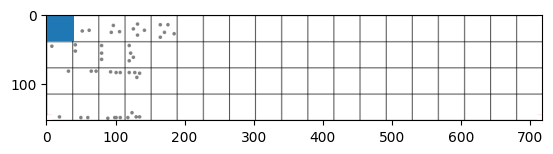

In [18]:
x = int(input('Row to select: '))
y = int(input('Col to select: '))
cell = coor2grid(grid, x, y)
# print(cell[0].shape)
print(cell)
fig, axes = plt.subplots()
axes.imshow(area_img)
axes.add_patch(Rectangle(
    cell[0, 0],                  # Starting point
    cell[3,0,1] - cell[0,0,1],   # Width
    cell[3,0,0] - cell[0,0,0]    # Height
))
plt.show()


In [21]:
def cut_cell(area:np.ndarray, cell:np.ndarray) -> np.ndarray:
    return area[ cell[0,0,0]+3:cell[1,0,0]-3, cell[0,0,1]+3:cell[3,0,1]-3]
    

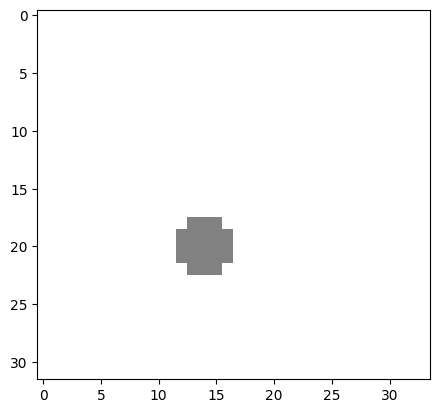

In [22]:
cell_a = cut_cell(area_img, cell)

plot_img(cell_a)